In [5]:
using Flux
using Gen
using Random
using Distributions
#using PyPlot
using LinearAlgebra
#using ArviZ
#using Plots

In [2]:
#Generate Data
n = 1000
Σ = [0.1 0.0; 0.0 0.1]
mu1 = [-0.5, -0.5]
mu2 = [-0.5, 0.5]
mu3 = [0.5, -0.5]
mu4 = [0.5, 0.5]

d1 = MvNormal(mu1, Σ)
d2 = MvNormal(mu2, Σ)
d3 = MvNormal(mu3, Σ)
d4 = MvNormal(mu4, Σ)

x1 = rand(d1,1000)
x2 = rand(d2,1000)
x3 = rand(d3,1000)
x4 = rand(d4,1000)
x = hcat(x1, x2, x3, x4)

labels = [Int(round(i/n % n, RoundDown) + 1) for i in range(0, 4n-1, step=1)]
y = float(Flux.onehotbatch(labels, [1,2,3,4]))
PyPlot.scatter(x[1,:],x[2,:], c=labels)

dataset = zip(Flux.unstack(transpose(x),1),Flux.unstack(transpose(y),1));

UndefVarError: UndefVarError: PyPlot not defined

In [7]:
#Make a Neural Network
model = Chain(
  Dense(2, 5, σ),
  Dense(5, 4),
  softmax)

loss(x, y) = Flux.crossentropy(model(x), y)
opt = Flux.ADAM()

#@Flux.epochs 10 Flux.train!(loss, Flux.params(model), dataset, opt);
for i in range(1,100,step=1)
    Flux.train!(loss, Flux.params(model), dataset, opt)
    if i % 20 == 0
        predictions = mapslices(argmax,model(x),dims=1)
        labels_accurate = [x == y ? 1 : 0 for (x,y) in zip(labels,predictions)]
        accuracy = sum(labels_accurate)/(4n)
        display(accuracy)
    end
end

0.815

0.79725

0.7965

0.799

0.79225

In [8]:
predictions = mapslices(argmax,model(x),dims=1)

for i=1:length(y[1,:])
    if labels[i] != predictions[i]
        predictions[i]=5
    end
end

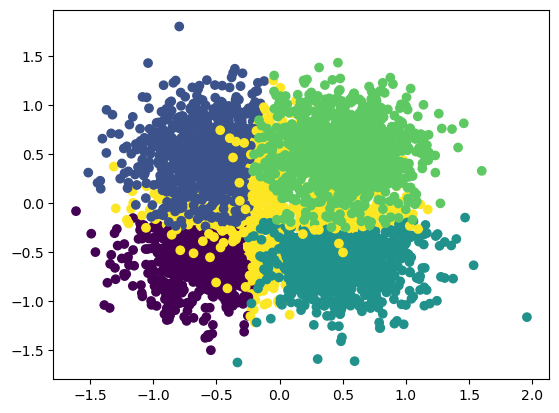

0.79225

In [9]:
using PyPlot
PyPlot.scatter(x[1,:],x[2,:], c=predictions)
labels_accurate = [x == y ? 1 : 0 for (x,y) in zip(labels,predictions)]
accuracy = sum(labels_accurate)/(4n)

In [12]:
##########
#Bayes Net
##########
function unpack(nn_params::AbstractVector)
    W₁ = reshape(nn_params[1:6], 3, 2);   
    b₁ = reshape(nn_params[7:9], 3)
    
    W₂ = reshape(nn_params[10:21], 4, 3); 
    b₂ = reshape(nn_params[22:25], 4)

    return W₁, b₁, W₂, b₂
end

# Construct a neural network using Flux and return a predicted value.
function nn_forward(xs, nn_params::AbstractVector)
    W₁, b₁, W₂, b₂ = unpack(nn_params)
    nn = Chain(Dense(W₁, b₁, tanh),
               Dense(W₂, b₂, tanh),
               softmax)
    return nn(xs)
end;

#Create a regularization term and a Gaussain prior variance term.
alpha = 0.09
sig = sqrt(1.0 / alpha)

# Specify the probabalistic model.
@gen function bayes_nn(xs, ts)
    # Create the weight and bias vector.
    μ = zeros(25)
    Σ = Diagonal(ones(25)*10)
    nn_params = @trace(mvnormal(μ,Σ), :p)
    
    # Calculate predictions for the inputs given the weights
    # and biases in theta.
    preds = nn_forward(xs, nn_params)
    
    for i=1:length(y[1,:])
        @trace(categorical(preds[:,i]), (:y, i)) 
    end
end;

#Set Observations for Traces
obs = Gen.choicemap()
    for (i, t) in enumerate(labels)
        obs[(:y, i)] = t
    end

#Simple HMC Algorithm for Finding Likely Parameter Values
function do_inference(x, y, num_iters)
    trace, = generate(bayes_nn, (x,y), obs)
    acc = []
    ps = []
    for i=1:num_iters
        trace, accepted = hmc(trace, select(:p), L=5, eps=0.1)
        push!(ps, trace)
        push!(acc,accepted)
        if i%10 == 0
            println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
        end
    end
    return ps, acc
end;

In [13]:
#Run Inference
z, acc = do_inference(x,y,500)
#display(z)
display(sum(acc)/length(acc))

Epoch 10 Acceptance Prob: 0.2
Epoch 20 Acceptance Prob: 0.35
Epoch 30 Acceptance Prob: 0.26666666666666666
Epoch 40 Acceptance Prob: 0.2
Epoch 50 Acceptance Prob: 0.16
Epoch 60 Acceptance Prob: 0.15
Epoch 70 Acceptance Prob: 0.14285714285714285
Epoch 80 Acceptance Prob: 0.1375
Epoch 90 Acceptance Prob: 0.13333333333333333
Epoch 100 Acceptance Prob: 0.17
Epoch 110 Acceptance Prob: 0.18181818181818182
Epoch 120 Acceptance Prob: 0.19166666666666668
Epoch 130 Acceptance Prob: 0.17692307692307693
Epoch 140 Acceptance Prob: 0.2
Epoch 150 Acceptance Prob: 0.21333333333333335
Epoch 160 Acceptance Prob: 0.225
Epoch 170 Acceptance Prob: 0.21176470588235294
Epoch 180 Acceptance Prob: 0.2
Epoch 190 Acceptance Prob: 0.2
Epoch 200 Acceptance Prob: 0.2
Epoch 210 Acceptance Prob: 0.2
Epoch 220 Acceptance Prob: 0.19545454545454546
Epoch 230 Acceptance Prob: 0.1956521739130435
Epoch 240 Acceptance Prob: 0.1875
Epoch 250 Acceptance Prob: 0.18
Epoch 260 Acceptance Prob: 0.17307692307692307
Epoch 270 Accep

0.092

Epoch 500 Acceptance Prob: 0.092


In [14]:
#Retrieve Parameter Traces
function retrieve_param_traces(samples)
    param_traces = Array{Float64}(undef,(500,25))
    for i in 1:length(samples)
        map = get_choices(samples[i])
        for j in 1:length(map[:p])
            param_traces[i,j] = map[:p][j]
        end
    end
    return param_traces
end;

params = retrieve_param_traces(z);

In [31]:
predicted = nn_forward(x, params[1,:])
display(predicted)


4×4000 Array{Float64,2}:
 0.0656363  0.0625081  0.0646828  …  0.0617136  0.0617218  0.0616594
 0.48499    0.461871   0.477945      0.455996   0.456057   0.455596
 0.0656363  0.0626368  0.0646828     0.0637264  0.0636497  0.0637379
 0.383737   0.412984   0.392689      0.418564   0.418571   0.419007